In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

## Set-up

In [47]:
import numpy as np
import torch
import cv2
import os
from pathlib import Path

torch.cuda.set_device(1)
#print(torch.cuda.current_device())

import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

from open_clip import tokenizer
import open_clip
open_clip.list_pretrained()
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

1


In [101]:

def mask_image(image, mask):
    """Masks an image with a binary mask, retaining color in the masked area and setting
       the rest to white.

    Args:
        image: The input image as a NumPy array.
        mask: The binary mask as a NumPy array, where 255 represents the masked area.

    Returns:
        The masked image as a NumPy array.
    """
    # 检查输入的图像和掩码是否为 NumPy 数组
    if not isinstance(image, np.ndarray) or not isinstance(mask, np.ndarray):
        raise ValueError("Both image and mask should be NumPy arrays.")

    # 检查图像和掩码的数据类型
    if image.dtype!= np.uint8 or mask.dtype!= np.uint8:
        raise ValueError("Both image and mask should have dtype of np.uint8.")

    # 检查掩码的大小是否与图像匹配
    if mask.shape[:2]!= image.shape[:2]:
        raise ValueError("The shape of the mask should match the shape of the image (excluding the number of channels).")
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image[mask == 0] = 255  # Set unmasked areas to white
    return masked_image


def save_mask(anns, path):

    #sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for i, ann in enumerate(anns):
        #a = ann['original_index']
        mask = ann['segmentation']
        mask = np.stack([mask]*3, axis=-1)   #如果不进行remove处理，这句不用注释

        img = (mask*255).astype(np.uint8)  # Setting mask as white
        cv2.imwrite(f'{path}/mask_{i}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


def crop_object_from_white_background(image):
   """Crops an image with a white background to the minimal bounding box containing a non-white object.
   """

   img = Image.fromarray(image)

   # Load the image
   img_array = np.array(image)

   # Find non-white pixels
   non_white_mask = np.any(img_array != 255, axis=2)  # Check all color channels

   # Find bounding box coordinates
   ymin, xmin = np.where(non_white_mask)[0].min(), np.where(non_white_mask)[1].min()
   ymax, xmax = np.where(non_white_mask)[0].max() + 1, np.where(non_white_mask)[1].max() + 1

   # Crop the image
   cropped_img = img.crop((xmin, ymin, xmax, ymax))

   return cropped_img



def show_anns_SDM(sorted_anns, image, save_path, borders=True):
    if len(sorted_anns) == 0:
        return
    
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image)
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for i, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

        # 标注掩码的索引
        y, x = np.mean(np.argwhere(m), axis=0).astype(int)
        ax.text(x, y, str(i), color='white', fontsize=15, ha='center', va='center', weight='bold')

    ax.imshow(img)
    plt.axis('off')
    plt.savefig(save_path)
    plt.close(fig)

def get_masked_image(image_segs_folder, rgb_image, mask_id):
    mask_img_path = image_segs_folder + "/mask_%i.png"%mask_id
    mask_img = cv2.imread(mask_img_path)[:, :, 0] # only one layer mask is needed
    masked_image = mask_image(rgb_image, mask_img)
    return masked_image


def clip_prediction(image_input, texts, labels):
    text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    label = labels[np.argmax(similarity)]
    print('第1轮标签', label)
    return label, similarity

In [49]:
def filter_masks_by_overlap(masks, threshold):
    masks_np = [np.array(mask['segmentation'], dtype=np.bool) for mask in masks]
    areas = [np.sum(mask) for mask in masks_np]
    keep = torch.ones(len(masks_np), dtype=torch.bool)
    scores = [mask['stability_score'] for mask in masks]
    keep = torch.ones(len(masks_np), dtype=torch.bool)

    # 遍历每个掩码
    for i in range(len(masks_np)):
        if not keep[i]:
            continue
        for j in range(i + 1, len(masks_np)):
            if not keep[j]:
                continue
            
            # 计算交集和 IoU
            intersection = np.logical_and(masks_np[i], masks_np[j]).astype(np.float32).sum()
            smaller_area = min(areas[i], areas[j])
            if intersection > threshold * smaller_area:
                if scores[i] < scores[j]:
                    keep[i] = False
                else:
                    keep[j] = False

    # 过滤后的掩码
    filtered_masks = [mask for idx, mask in enumerate(masks) if keep[idx]]
    
    return filtered_masks

## Example image

/home/nya/code/StrawDI/data_seg/images/train/58.png


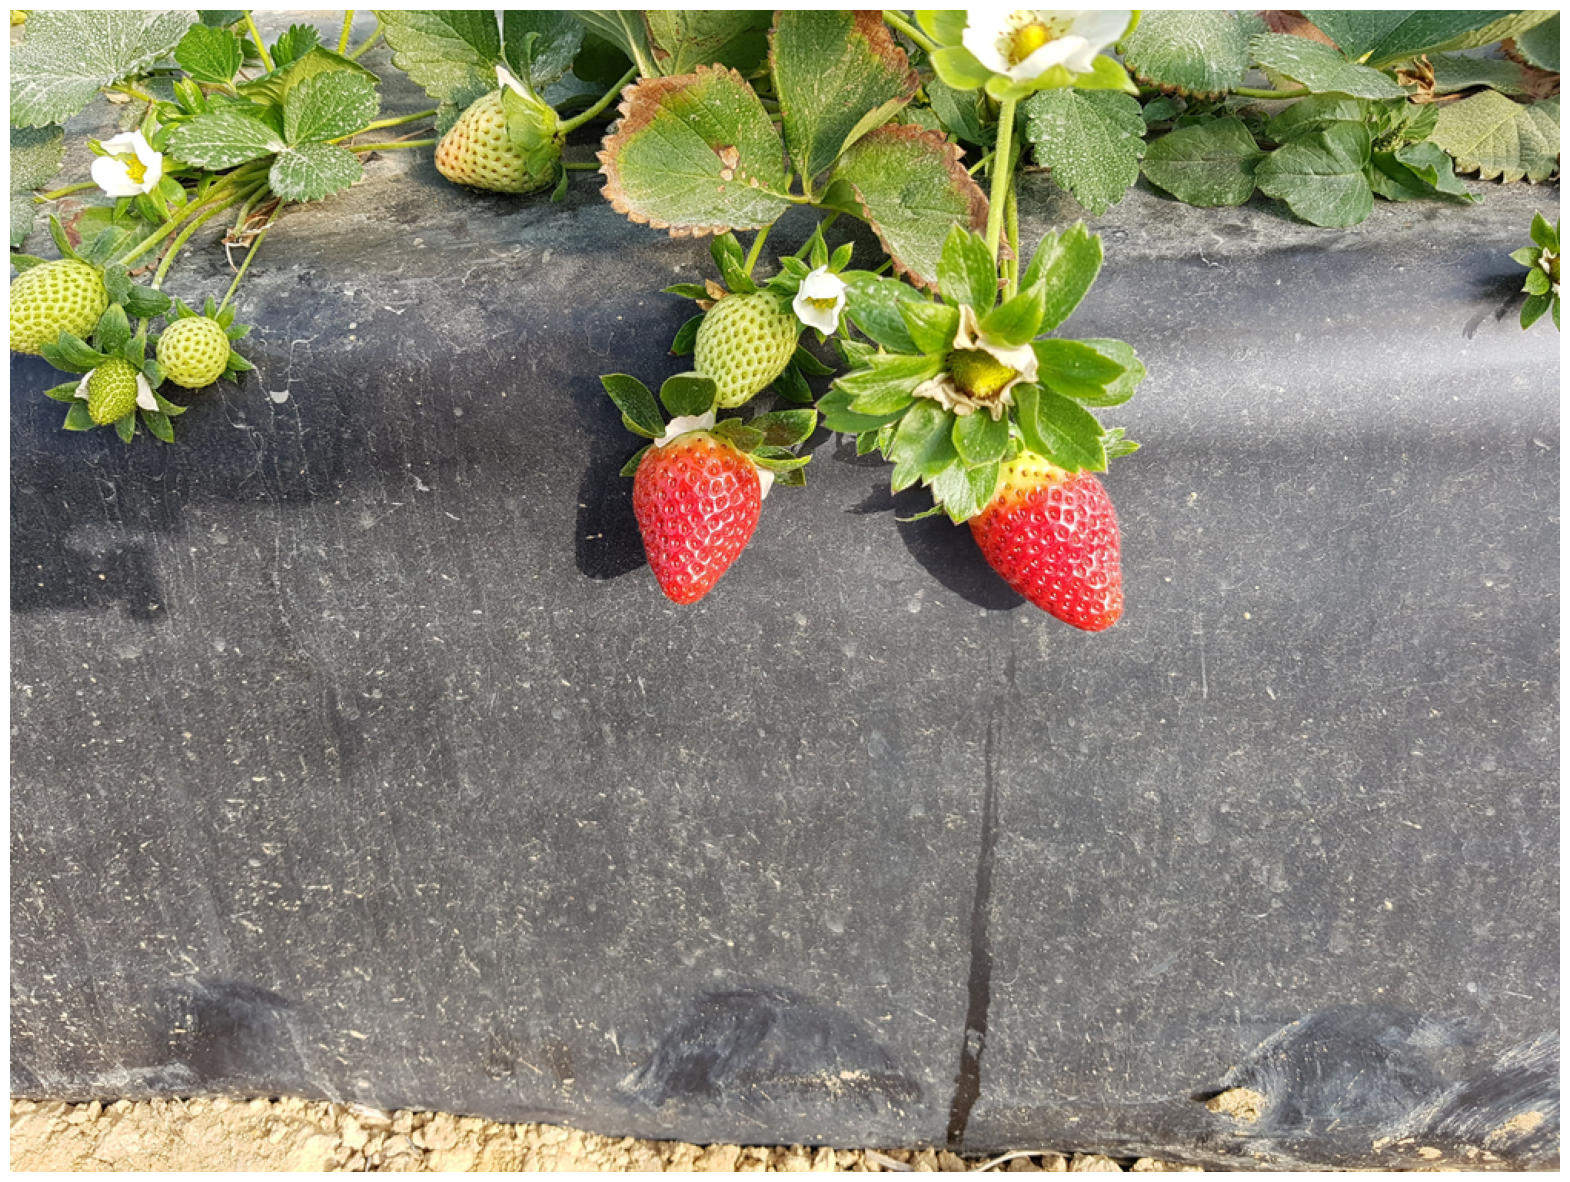

In [98]:
image_segs_folder = "../Images/strawberry"
masks_segs_folder = '../notebooks/output/mask'
va_all_output_path = '../notebooks/output/visual_mask'
id = str('58')
img_path = os.path.join(image_segs_folder, f'{id}.png')
print(img_path)
image = Image.open(img_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [77]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
mask_nms_key = True
mask_nms_thresh = 0.9
sam2 = build_sam2(model_cfg, sam2_checkpoint, device ='cuda', apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2, points_per_side=32, min_mask_region_area=50)
masks = mask_generator.generate(image)

To generate masks, just run `generate` on an image.

In [78]:
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
if mask_nms_key:
    sorted_anns = filter_masks_by_overlap(sorted_anns, mask_nms_thresh)

va_all_path = os.path.join(va_all_output_path, f'{id}.png')
print('va_all_path', va_all_path)
path_stem = os.path.join(masks_segs_folder, id)
image = cv2.imread(img_path)
show_anns_SDM(sorted_anns, image, va_all_path)
print('path_stem', path_stem)
os.makedirs(path_stem, exist_ok=True)


va_all_path /home/nya/code/code/segment-anything-2/notebooks/output/visual_mask/58.png
path_stem /home/nya/code/code/segment-anything-2/notebooks/output/mask/58


54


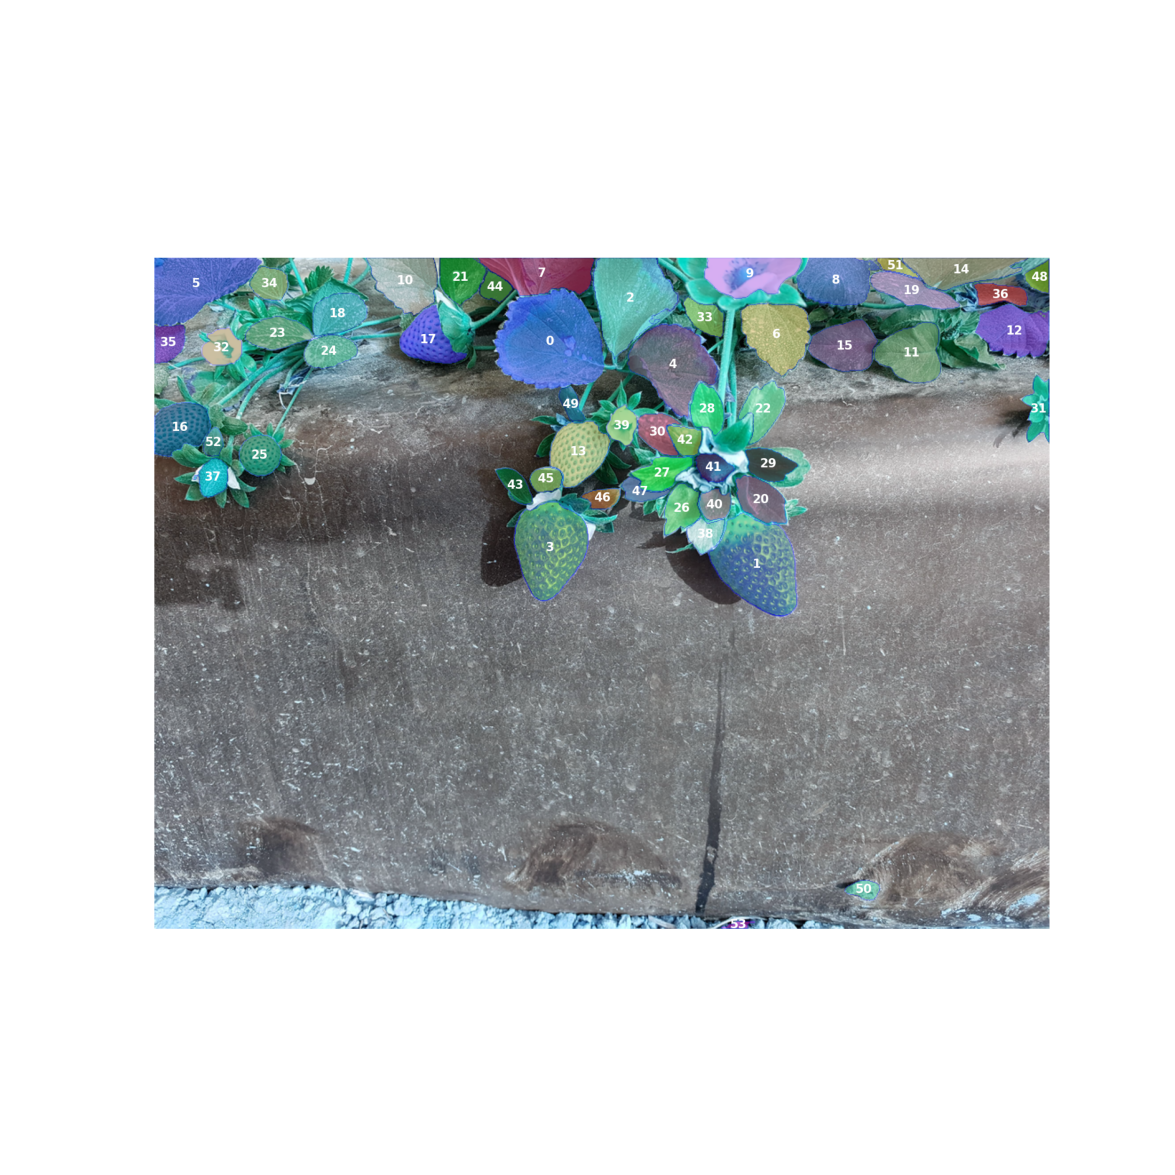

In [79]:
save_mask(sorted_anns, path_stem)
print(len(sorted_anns))

mask_all_img = Image.open(va_all_path)
plt.figure(figsize=(15,15))
plt.imshow(mask_all_img)
plt.axis('off')
plt.show() 



Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

54
[22, 3, 52, 10, 25, 50, 27, 9]


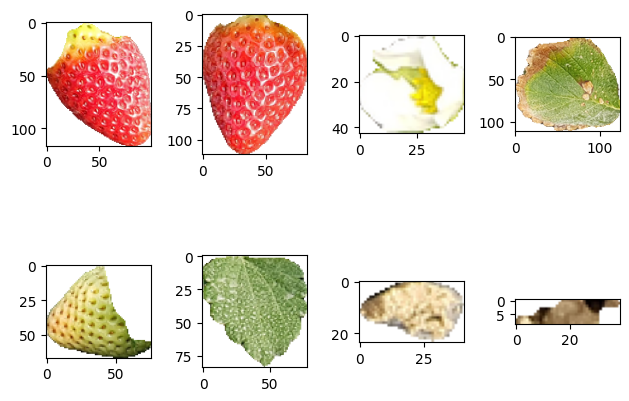

In [103]:

img = cv2.imread(img_path) 

rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else print("No image file found with .jpg or .png extensions.")
image_segs_folder = os.path.join(masks_segs_folder, id)
print(len(os.listdir(image_segs_folder)))
original_images = []
images = []
mask_ids = [random.randint(0, len(os.listdir(image_segs_folder))-1) for _ in range(8)]
print(mask_ids)
mask_ids = [1, 3, 32, 0, 17, 6, 50, 53]  #str  58.png
for i, mask_id in enumerate(mask_ids):
    masked_image = get_masked_image(image_segs_folder, rgb_image, mask_id)
    image = crop_object_from_white_background(masked_image)
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    original_images.append(image)
    images.append(preprocess(image))

plt.tight_layout()



## OpenCLIP label assignment

In [104]:
texts = [
"a red strawberry",  
"a pale green strawberry with numerous points",
"a green veined strawberry leaf",
"a long and thin stem",
"a white flower",
"soil or background or something else",
]
labels = ['ripe', 'unripe', 'leaf','stem','flower','others']
label_dict = {"ripe": 0, "unripe": 1, "leaf": 2, "stem": 3, "flower": 4,"others": 5}

[[0.3229688  0.32379514 0.12273779 0.18251397 0.24067792 0.1862936
  0.12619646 0.13123316]
 [0.26965022 0.28608906 0.19527805 0.27964553 0.30947503 0.29216072
  0.16202118 0.1481193 ]
 [0.25644058 0.25455213 0.21389309 0.3184358  0.2611981  0.31998274
  0.16257912 0.15110439]
 [0.19355209 0.18951848 0.1841909  0.21584144 0.20309205 0.22200623
  0.17370586 0.17842045]
 [0.11892261 0.11159695 0.21711999 0.16781381 0.20720115 0.19486961
  0.17983511 0.14457549]
 [0.15578702 0.12851878 0.15255567 0.1930435  0.15510514 0.19789302
  0.19808535 0.24439302]]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

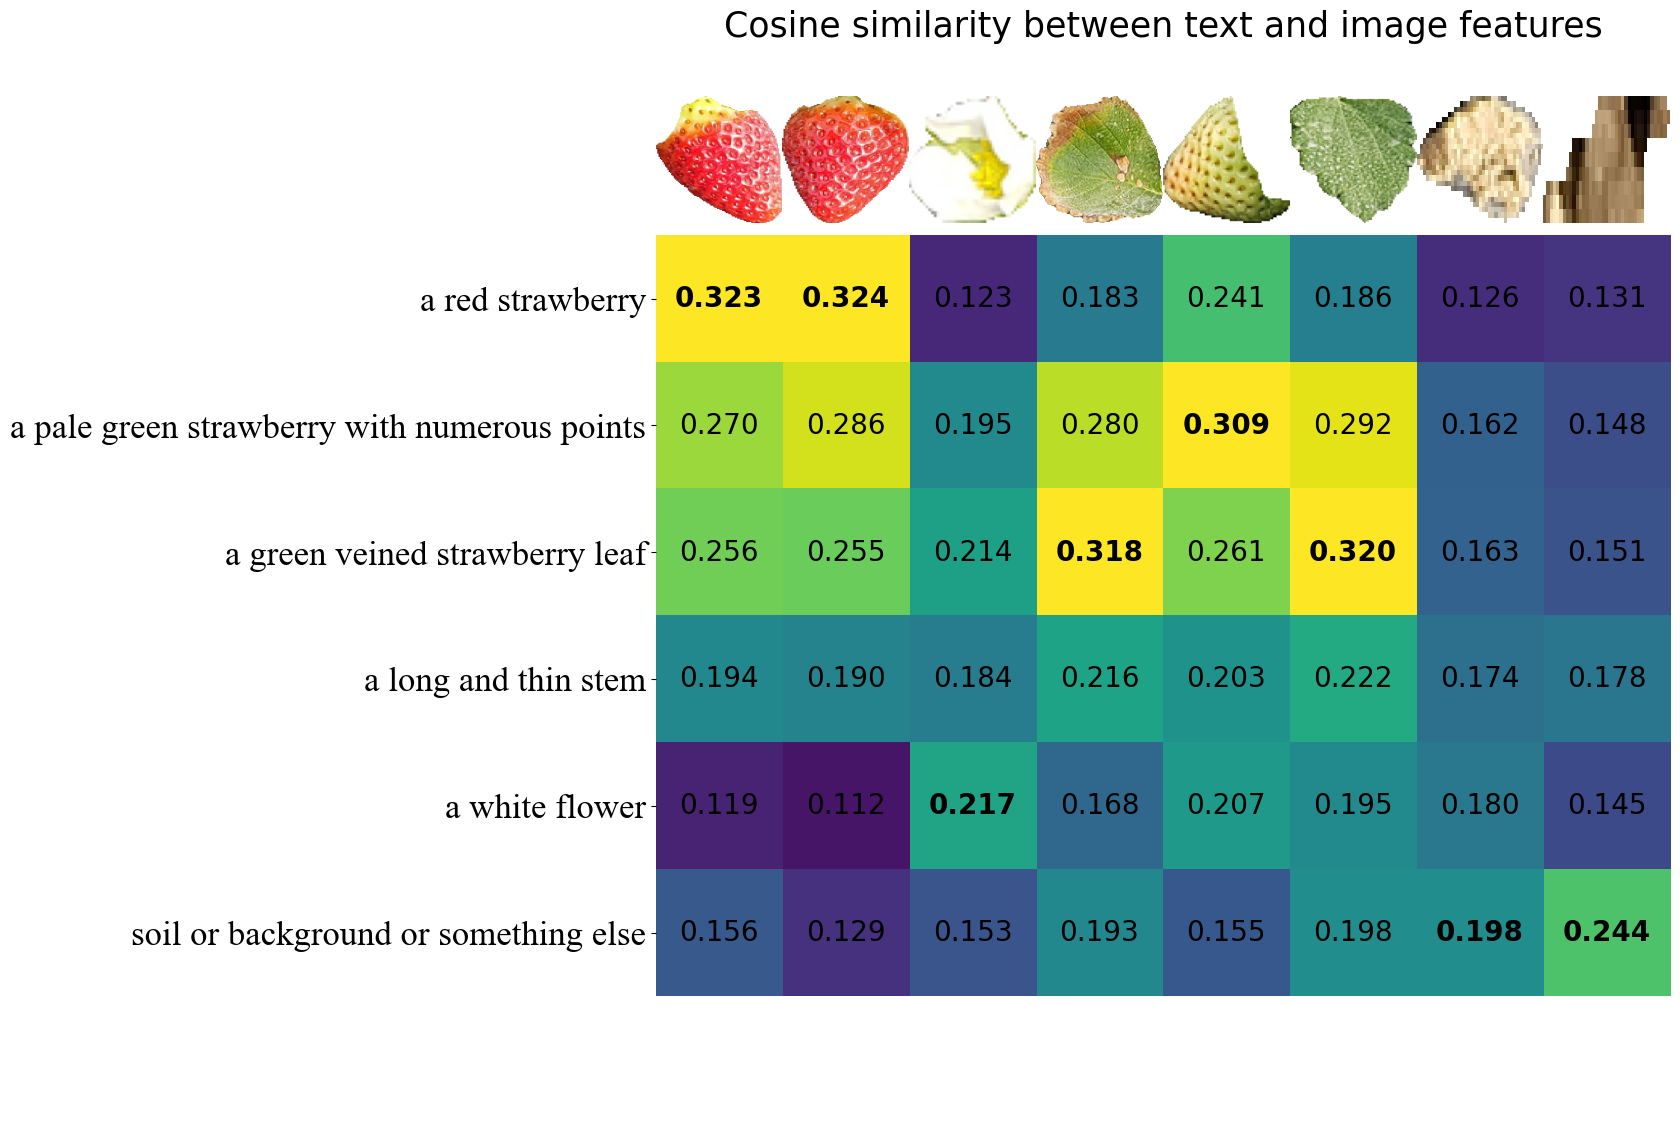

In [107]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])
image_input = torch.tensor(np.stack(images))
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
print(similarity)
count = len(texts)

plt.figure(figsize=(25, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
font_properties = FontProperties(fname=r'/home/nya/code/code/times.ttf')
plt.yticks(range(count), texts, fontproperties=font_properties, fontsize=25)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):  # Iterate over columns
    column = similarity[:, x]
    max_idx = column.argmax()  # Index of the maximum value in the column
    for y in range(similarity.shape[0]):  # Iterate over rows
        text_style = {"weight": "bold"} if y == max_idx else {}  # Bold for max value
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=20, **text_style)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(original_images) - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=25)

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.6]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=5) 

    ax.imshow(img)

In [110]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [114]:
image = Image.open(img_path)
image = np.array(image.convert("RGB"))
masks2 = mask_generator_2.generate(image)


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 